In [1]:
%matplotlib inline
import shutil
import matplotlib
matplotlib.rc('font', family='arial') 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import cm
from scipy.interpolate import interp1d
import numpy as np
from skimage.io import imread
from fish.image.zds import ZDS
from fish.ephys.ephys import load
from fish.util.distributed import get_jobqueue_cluster
import dask.array as da
from dask.distributed import Client
from dask.array import coarsen
from functools import partial
from h5py import File
import flika as flk
import time
import attr
flk.start_flika()
from flika.window import Window as flw
from skimage.transform import downscale_local_mean
from scipy.ndimage.filters import median_filter

from skimage.exposure import rescale_intensity as rescale
from scipy.ndimage.filters import gaussian_filter
from moviepy.editor import ImageSequenceClip, VideoClip, concatenate_videoclips
from moviepy.video.io.bindings import mplfig_to_npimage

Starting flika
Starting flika inside IPython


In [2]:
def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

def mydff(v, fs_im):
    from fish.image.vol import dff
    camera_offset = 100
    window = 300 * fs_im
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

In [3]:
base_dir = '/nrs/ahrens/Yu/SPIM/active_dataset/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/'
dset = ZDS(base_dir + 'raw/')
exp_name = dset.metadata['data_header']
fs_im = dset.metadata['volume_rate']

shifts = -np.load(base_dir + 'regparams_affine.npy')[:,:-1,-1]
shifts = median_filter(shifts, size=(300,1))

In [4]:
sample =dset.data[0].compute()

In [5]:
roi = (slice(292, 500), slice(None), slice(1024,None), slice(None))

In [6]:
data = dset.data[roi]
data_tx = data.map_blocks(shift_yx, shifts[roi[0]], dtype='float32')
medfilt = partial(median_filter, size=(1,1,5,5))
data_filt = data_tx.map_blocks(medfilt)

ds_xy = 4
data_ds = coarsen(np.mean, data_filt, {2: ds_xy, 3: ds_xy})
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], -1, -1,'auto'))
data_dff = rechunked.map_blocks(lambda v: mydff(v, fs_im), dtype='float32')

ref_range = slice(0, 10)
ref = data_ds[ref_range].mean(0).compute(scheduler='threads')
out_path = f'/nrs/ahrens/davis/tmp/{exp_name}_allplanes_t{roi[0].start}t{roi[0].stop}.npy'

In [7]:
cluster = get_jobqueue_cluster()
client = Client(cluster)
client

<Client: scheduler='tcp://10.36.111.12:40061' processes=0 cores=0>

In [12]:
cluster.start_workers(300)
result_dff = data_dff.compute()
cluster.stop_all_jobs()

In [13]:
np.save(out_path, result_dff)

In [8]:
result_dff = np.load(out_path)

In [9]:
result_dff.shape

(208, 29, 256, 512)

In [13]:
from dask import delayed
from fish.util.plot import apply_cmap
from skimage.util import montage
def make_montage(im):
    return montage(im.transpose((0,2,1)), grid_shape=(3,10), fill=0)

sample = make_montage(result_dff[0])
vol = da.stack([da.from_delayed(delayed(make_montage)(r), shape=sample.shape, dtype=sample.dtype) for r in result_dff])
ref_mont = make_montage(ref)

In [14]:
res = vol.compute(scheduler='threads')

In [21]:
from skimage.io import imsave
out_fname = f'/groups/ahrens/ahrenslab/projects/ngm/presentation/movies/{exp_name}_frames_for_misha.tif'
to_save = np.stack([res, np.array(res.shape[0] * [ref_mont])])
imsave(out_fname, to_save, imagej=True)

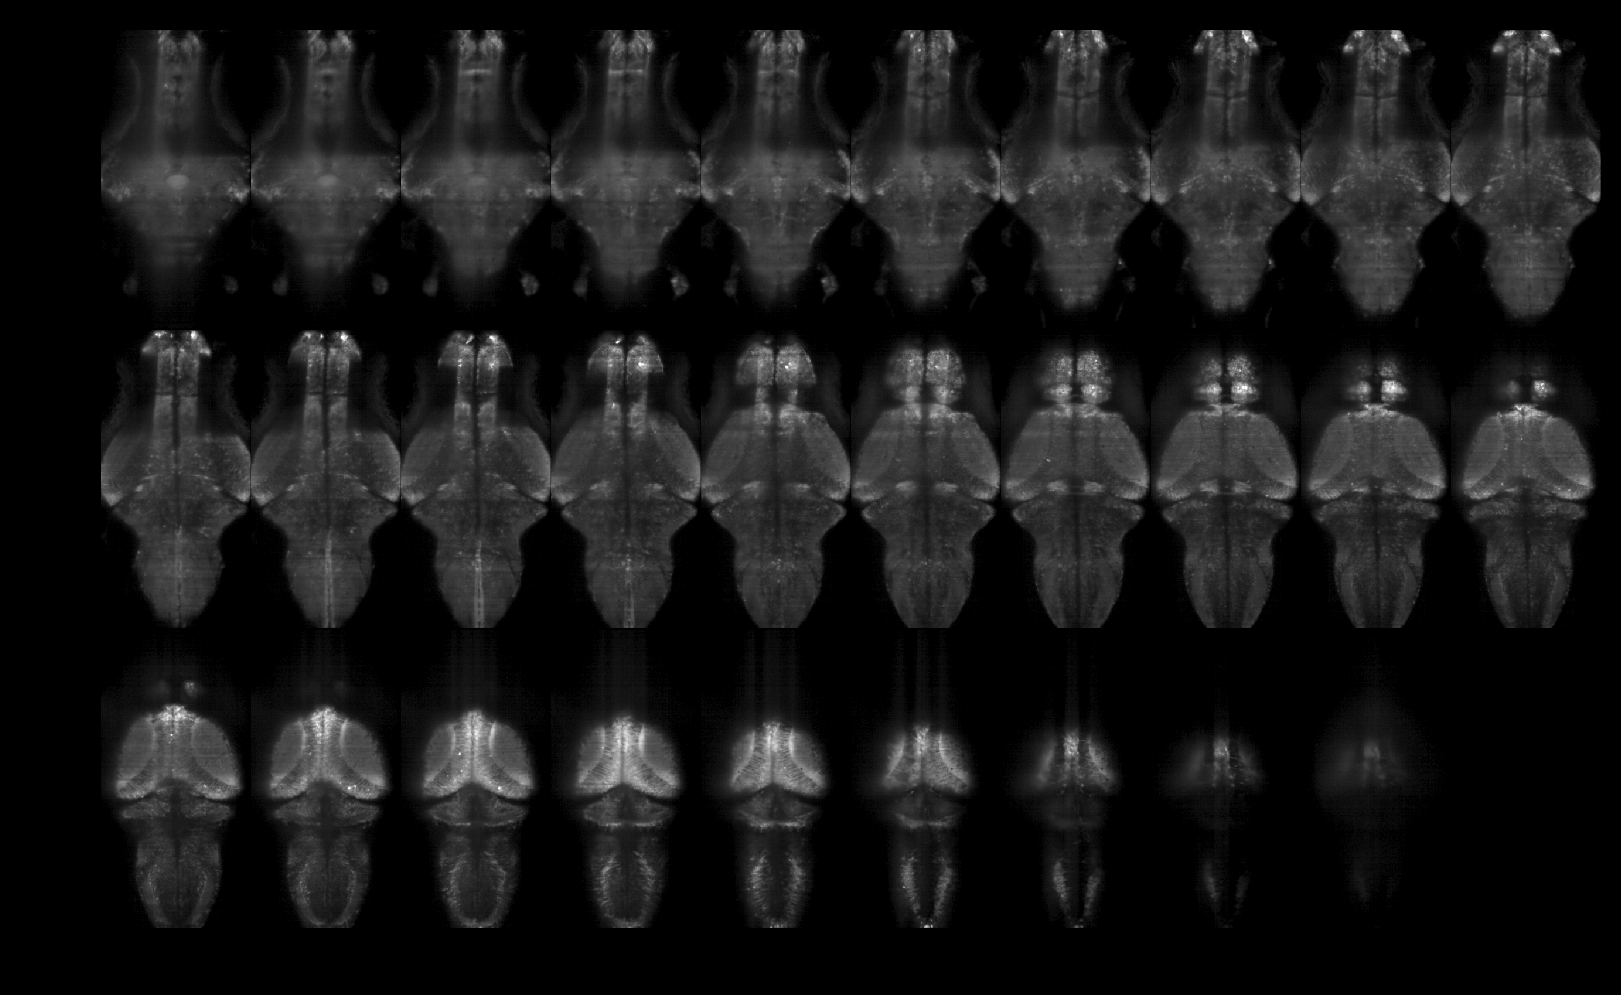

In [60]:
from skimage.exposure import rescale_intensity as rescale
fps = 24
data_dur = 7
playback_scale = (res.shape[0] / fs_im) / data_dur
figsize=(8,4.5)

ref_resc = rescale(ref_mont, in_range=(100,200), out_range=(0,1)) ** .6
anat_rgb = apply_cmap(ref_resc, cmap='gray')
fig = plt.figure(dpi=200, figsize=figsize)
fig.set_facecolor('k')
axs = fig.add_axes((0,0,1,1))
axs.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
res_interp = interp1d(np.linspace(0, data_dur, res.shape[0]), res, axis=0, bounds_error=False)
axs.imshow(anat_rgb)
def drawf(t):
    composite = anat_rgb + apply_cmap(res_interp(t), clim=(.2, .7), cmap='hot')
    axs.images[0].set_data(composite)
    return mplfig_to_npimage(fig)

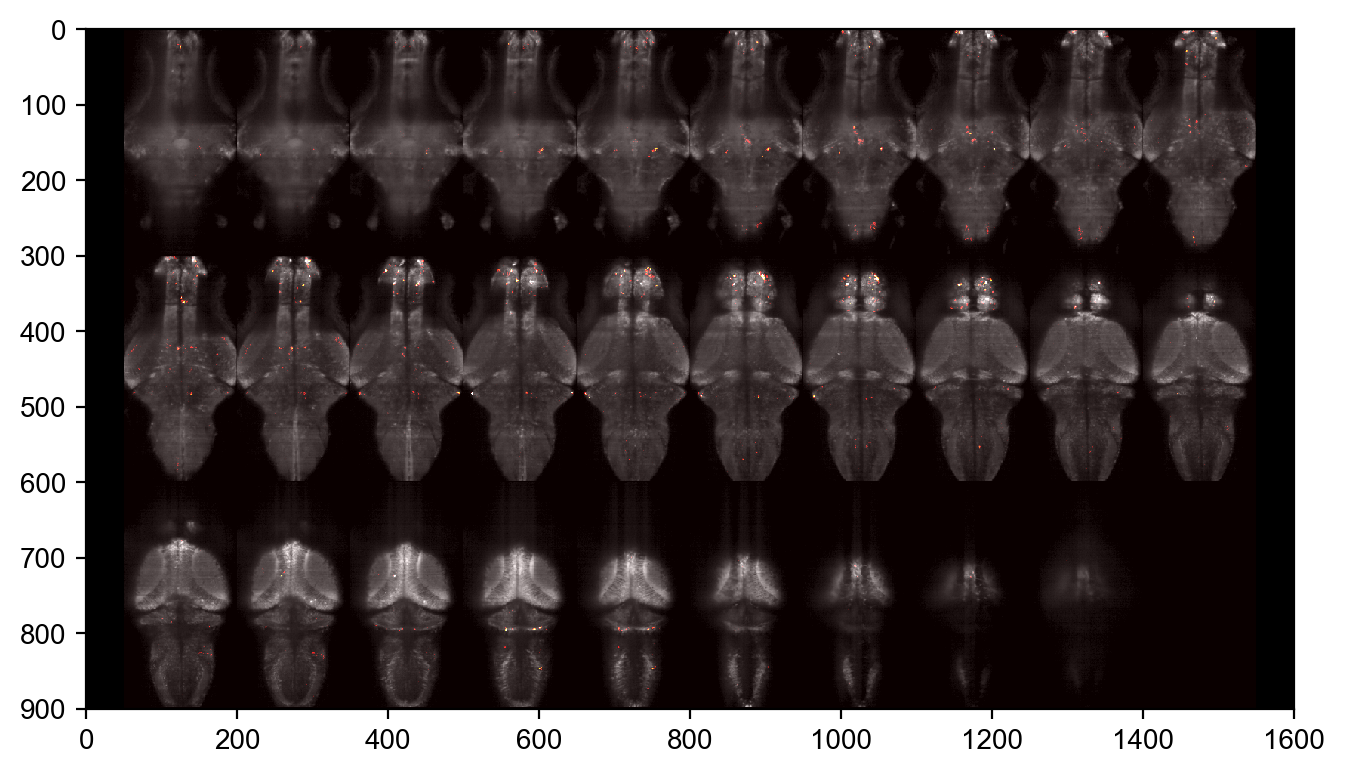

In [54]:
f, ax = plt.subplots(dpi=200, figsize=(8,4.5))
ax.imshow(drawf(3))

In [55]:
clip = VideoClip(drawf, duration=data_dur)

In [56]:
codec = 'h264'
vid_fname = f'/nrs/ahrens/davis/tmp/{exp_name}_t{roi[0].start}t{roi[0].stop}_dur{data_dur}_planar.mp4'
clip.write_videofile(vid_fname, audio=False, codec=codec, fps=fps, ffmpeg_params=['-pix_fmt', 'yuv420p'])


t:   0%|          | 0/168 [00:00<?, ?it/s, now=None]

Moviepy - Building video /nrs/ahrens/davis/tmp/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_t292t500_dur7_planar.mp4.
Moviepy - Writing video /nrs/ahrens/davis/tmp/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_t292t500_dur7_planar.mp4



Moviepy - Done !
Moviepy - video ready /nrs/ahrens/davis/tmp/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_t292t500_dur7_planar.mp4


In [58]:
from moviepy.editor import VideoFileClip
VideoFileClip(vid_fname).ipython_display(maxduration=100)

t:   5%|▍         | 8/168 [00:00<00:02, 79.77it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
